<a href="https://colab.research.google.com/github/rupali-p/recycling-app/blob/tammy%2Fml-experiments/Tammy_ML_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Try create a simple resin code identification model
Based on https://www.kaggle.com/code/cheedcheed/fine-tuning-mobilenet-for-resin-id-codes

Used the Free Google Colab GPU to train model ~15 minutes
Recommend uploading training data zip and then unzipping file

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [53]:
# !unzip resin_codes_zip.zip

In [54]:
img_height, img_width = IMG_SIZE = (200, 200)
batch_size = 322

data_dir = "seven_plastics"

## Load images

In [55]:
train_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 685 files belonging to 8 classes.
Using 617 files for training.


In [56]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 685 files belonging to 8 classes.
Using 68 files for validation.


In [57]:
# List the classes

class_names = train_ds.class_names
class_names

['1_polyethylene_PET',
 '2_high_density_polyethylene_PE-HD',
 '3_polyvinylchloride_PVC',
 '4_low_density_polyethylene_PE-LD',
 '5_polypropylene_PP',
 '6_polystyrene_PS',
 '7_other_resins',
 '8_no_plastic']

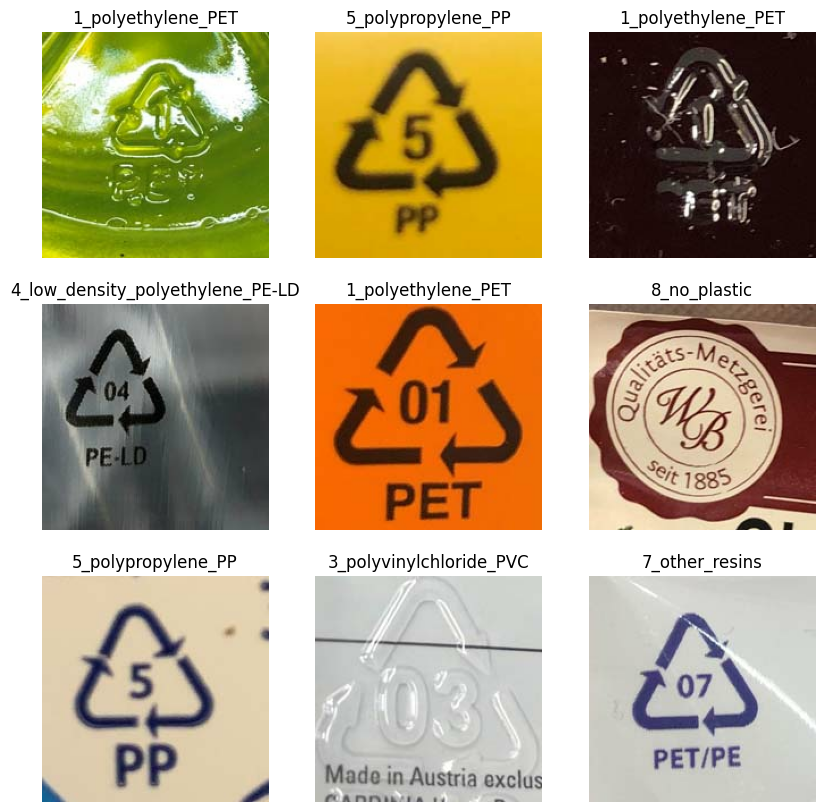

In [58]:
# Examine the training data

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [59]:
# Prefetch images to memory, to speed up training

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

## Data Augumentation

In [60]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [61]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Use MobileNet for transfer learning

In [62]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [63]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(322, 7, 7, 1280)


In [64]:
# Keep the pre-trained weights, set this to true to retrain the whole model.
base_model.trainable = False

In [65]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(322, 1280)


In [66]:
num_classes = len(class_names)

prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(322, 8)


## Build the Model

In [68]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [69]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(), # lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [70]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 200, 200, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 200, 200, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [71]:
initial_epochs = 300

loss0, accuracy0 = model.evaluate(val_ds)

1/1 [==============================] - 2s 2s/step - loss: 2.4637 - accuracy: 0.1029


In [72]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/300
2/2 [==============================] - 8s 2s/step - loss: 2.3276 - accuracy: 0.1556 - val_loss: 2.2098 - val_accuracy: 0.2059
Epoch 2/300
2/2 [==============================] - 1s 422ms/step - loss: 2.1282 - accuracy: 0.2415 - val_loss: 2.1078 - val_accuracy: 0.2500
Epoch 3/300
2/2 [==============================] - 1s 413ms/step - loss: 1.9851 - accuracy: 0.2804 - val_loss: 1.9716 - val_accuracy: 0.2647
Epoch 4/300
2/2 [==============================] - 1s 417ms/step - loss: 1.8872 - accuracy: 0.3031 - val_loss: 1.8849 - val_accuracy: 0.3088
Epoch 5/300
2/2 [==============================] - 1s 428ms/step - loss: 1.7524 - accuracy: 0.3501 - val_loss: 1.8181 - val_accuracy: 0.3971
Epoch 6/300
2/2 [==============================] - 1s 421ms/step - loss: 1.6884 - accuracy: 0.3566 - val_loss: 1.7591 - val_accuracy: 0.4265
Epoch 7/300
2/2 [==============================] - 1s 427ms/step - loss: 1.6231 - accuracy: 0.4068 - val_loss: 1.7208 - val_accuracy: 0.4265
Epoch 8/300
2/2 

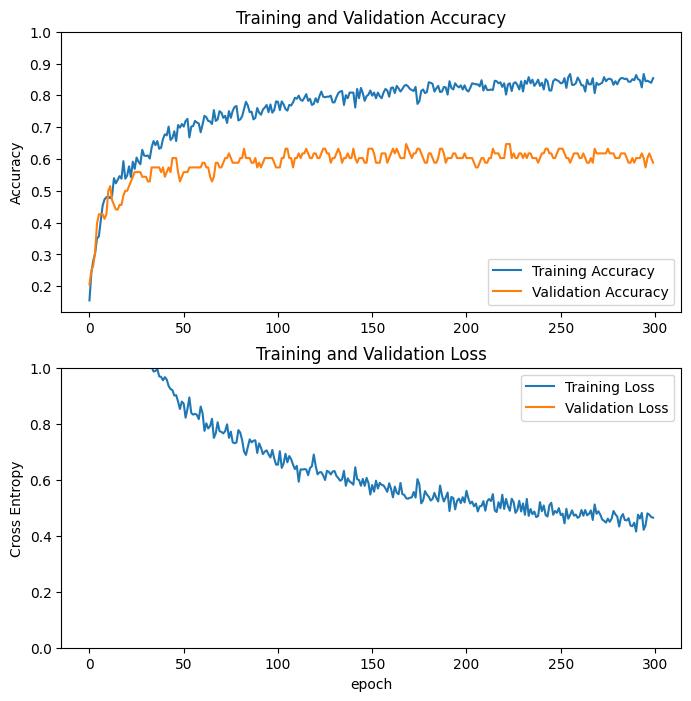

In [73]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [76]:
# Input data examination
import os
from collections import Counter
import PIL
import PIL.Image

for dirname, _, filenames in os.walk(data_dir):
    c = Counter()

    for filename in filenames:
        with PIL.Image.open(str(os.path.join(dirname, filename))) as im:
            c.update([im.size])

    print(os.path.basename(dirname))

    for key, value in c.items():
        print(key, value)


seven_plastics
2_high_density_polyethylene_PE-HD
(200, 200) 72
(199, 200) 4
4_low_density_polyethylene_PE-LD
(200, 200) 89
(200, 199) 1
1_polyethylene_PET
(200, 200) 110
(199, 200) 6
(200, 199) 5
8_no_plastic
(200, 200) 71
(200, 130) 1
(180, 200) 1
(200, 199) 2
(199, 200) 1
(150, 200) 1
(200, 176) 1
(200, 192) 1
6_polystyrene_PS
(200, 200) 37
(199, 200) 1
(200, 199) 1
5_polypropylene_PP
(200, 200) 171
(200, 199) 12
(200, 198) 1
(199, 200) 8
3_polyvinylchloride_PVC
(200, 200) 24
7_other_resins
(199, 200) 3
(200, 200) 58
(198, 200) 2
(200, 199) 1
